<a href="https://colab.research.google.com/github/DJ1070/NLP/blob/main/nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
#from nltk.stem import PorterStemmer 
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
#import matplotlib.cm as cm
#from matplotlib import rcParams
from collections import Counter
#from nltk.tokenize import RegexpTokenizer
import re
import string
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [28]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/training.1600000.processed.noemoticon.csv', header = None)

In [29]:
df

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [30]:
df = df.drop([1, 2, 3, 4], axis = 1)

In [31]:
df.columns = ['label', 'tweet']

In [32]:
df['label'] = df['label'].replace(4, 1)

In [33]:
nltk.download('stopwords')
list_stopwords = stopwords.words('english')
stemmer = SnowballStemmer('english')
regex = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
def preprocess(text):
  text = re.sub(regex, ' ', str(text).lower()).strip()
  words = [] # new/cleaned sentence
  for word in text.split():
    if word not in list_stopwords:
      words.append(stemmer.stem(word))
  return " ".join(words)

In [35]:
df.tweet = df.tweet.apply(lambda x: preprocess(x))

In [36]:
df

,label,tweet
0,0,awww bummer shoulda got david carr third day
1,0,upset updat facebook text might cri result sch...
2,0,dive mani time ball manag save 50 rest go bound
3,0,whole bodi feel itchi like fire
4,0,behav mad see
...,...,...
1599995,1,woke school best feel ever
1599996,1,thewdb com cool hear old walt interview
1599997,1,readi mojo makeov ask detail
1599998,1,happi 38th birthday boo alll time tupac amaru ...


In [37]:
X = df['tweet'].to_list()
y = df['label'].to_list()

In [38]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = .2, random_state = 3)

In [39]:
vocab_size = 255000
embedding_dim = 16
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"


make_tokens = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
make_tokens.fit_on_texts(x_train)

word_dict = make_tokens.word_index

training_sequences = make_tokens.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = make_tokens.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
#testing_padded[0:5]
len(word_dict)
#word_dict

248708

In [40]:
embeddings_dictionary = dict()
embedding_dim = 100

In [41]:
glove_file = open('/content/drive/MyDrive/Colab Notebooks/glove_100d_6b.txt')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
    
glove_file.close()

embeddings_matrix = np.zeros((vocab_size, embedding_dim))

word_list = list(word_dict.keys())[0:vocab_size]
for iword, word in enumerate(word_list):
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embeddings_matrix[iword] = embedding_vector

In [42]:
embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 100)           25500000  
_________________________________________________________________
bidirectional (Bidirectional (None, 16, 256)           234496    
_________________________________________________________________
dropout (Dropout)            (None, 16, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16, 256)           394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 256)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 16, 256)           394240    
_________________________________________________________________
dense (Dense)                (None, 16, 64)            1

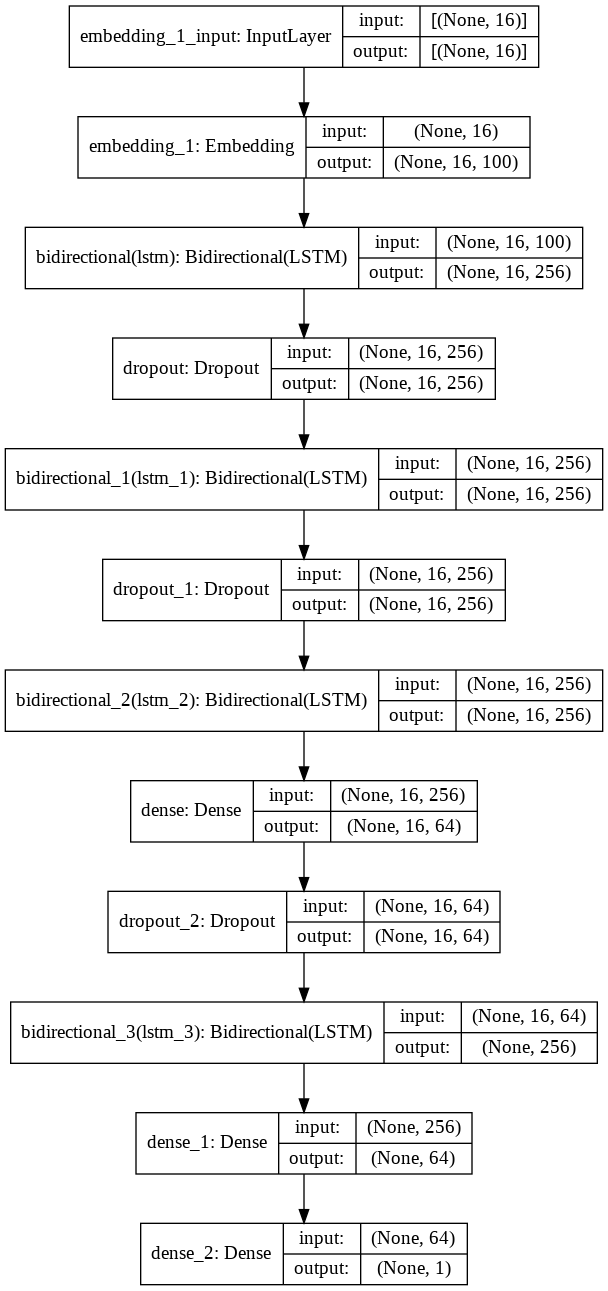

In [43]:
model = tf.keras.Sequential([
        #embedding_layer,
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

path = \
'model_checkpoint/at_{epoch}-{val_accuracy}'

model_checkpoint = ModelCheckpoint(filepath= path,
                             save_weights_only = True,
                             monitor = 'val_accuracy',
                             mode = 'max',
                             save_best_only = True,
                             save_freq = 'epoch',
                             verbose = 1)

In [46]:
y_train_labels = y_train
y_test_labels = y_test

In [47]:
num_epochs = 5
training_labels = np.array(y_train_labels)
testing_labels  = np.array(y_test_labels)
training_padded = np.array(training_padded)
testing_padded  = np.array(testing_padded)

history = model.fit(training_padded, training_labels,
                    batch_size = 128,
                    epochs=num_epochs,
                    validation_split= .25,
                    callbacks = [
                                 model_checkpoint,
                                 ReduceLROnPlateau(monitor= 'val_loss', cooldown=0, patience= 2),
                                 EarlyStopping(monitor = 'val_loss', min_delta = 0.0001, patience = 2)
                                 ],
                    verbose=1)

Epoch 1/5
7500/7500 [==============================] - 5615s 747ms/step - loss: 0.4990 - accuracy: 0.7529 - val_loss: 0.4636 - val_accuracy: 0.7786

Epoch 00001: val_accuracy improved from -inf to 0.77861, saving model to model_checkpoint/at_1-0.7786093950271606
Epoch 2/5
7500/7500 [==============================] - 5525s 737ms/step - loss: 0.4204 - accuracy: 0.8053 - val_loss: 0.4606 - val_accuracy: 0.7824

Epoch 00002: val_accuracy improved from 0.77861 to 0.78241, saving model to model_checkpoint/at_2-0.7824125289916992
Epoch 3/5
7500/7500 [==============================] - 5512s 735ms/step - loss: 0.3683 - accuracy: 0.8336 - val_loss: 0.4901 - val_accuracy: 0.7720

Epoch 00003: val_accuracy did not improve from 0.78241
Epoch 4/5
7500/7500 [==============================] - 5557s 741ms/step - loss: 0.3134 - accuracy: 0.8589 - val_loss: 0.5505 - val_accuracy: 0.7679

Epoch 00004: val_accuracy did not improve from 0.78241


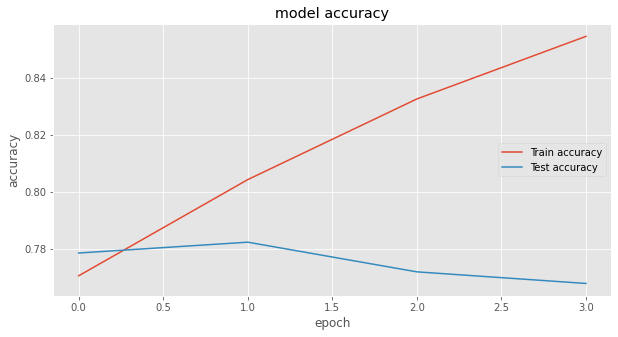

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train accuracy', 'Test accuracy'], loc='right')
plt.show()